In [1]:
# Magic Commands
%matplotlib inline

# Python Packages
from time import time

# Third-Party Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Local Packages
from utils import decision_areas, ID3, plot_areas, plot_tree

In [2]:
# Matplotlib Default Configuration
mpl.rc('axes', titlesize=8)
mpl.rc('grid', linestyle=':')

In [3]:
# Constants
FIG_WIDTH, FIG_HEIGHT = 11, 4

# Decision Tree Learning

## Non-Linear Relationships

In [4]:
np.random.seed(1909)
samples = 30

x1, x2 = list(np.random.uniform(2.5, 7.5, samples + 50)), list(np.random.uniform(2.5, 7.5, samples + 50))
x11 = list(np.random.uniform(0, 2, samples)) + list(np.random.uniform(8, 10, samples)) + list(np.random.uniform(2, 8, samples)) + list(np.random.uniform(2, 8, samples))
x22 = list(np.random.uniform(0, 10, samples)) + list(np.random.uniform(0, 10, samples)) + list(np.random.uniform(0, 2, samples)) + list(np.random.uniform(8, 10, samples))

nle = pd.DataFrame({'X1': x1 + x11, 'X2': x2 + x22})
nle['Y'] = np.where(((nle['X1'] >= 2.5) & (nle['X1'] <= 7.5)) & ((nle['X2'] >= 2.5) & (nle['X2'] <= 7.5)), 1, 0)

X, y = nle[['X1', 'X2']].values, nle['Y'].values

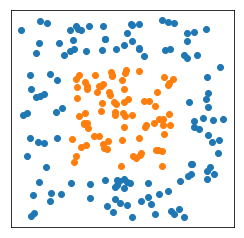

In [5]:
fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

ax.scatter(X[np.where(y == 0), 0], X[np.where(y == 0), 1])
ax.scatter(X[np.where(y == 1), 0], X[np.where(y == 1), 1])

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('../slides/figures/non-linear-relationships.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

-1.0 11.0 0.0 -8.409871816635132
-1.0 2.2559601068496704 3.590128183364868 5.255132794380188
2.2559601068496704 7.82994270324707 0.33416807651519775 -0.3188498020172119
7.82994270324707 11.0 -5.239814519882202 -3.4889070987701416
-1.0 11.0 8.511092901229858 0.0


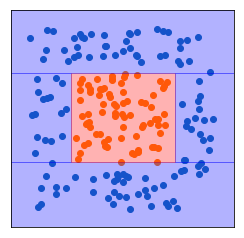

In [6]:
fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

clf = DecisionTreeClassifier().fit(X, y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax.scatter(X[np.where(y == 0), 0], X[np.where(y == 0), 1])
ax.scatter(X[np.where(y == 1), 0], X[np.where(y == 1), 1])
rectangles = decision_areas(clf, [-1, 11, -1, 11])
plot_areas(rectangles)

ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_yticks([])
ax.set_xticks([])

plt.savefig('../slides/figures/bisections.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## Introductory Example

In [7]:
data = pd.read_csv('../datasets/demos/outages.csv')

In [8]:
table = data.copy()
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]]).reset_index(drop=True)
table.columns = ['Vibration Intensity', 'Error Indicator', 'Temperature', 'Outage Indicator']
table.insert(0, 'i', [*range(1, 4), '...', len(data)])
table.to_latex('../slides/tables/outage-dataset.tex', column_format='crrrr', index=False, escape=False)

In [9]:
table = data.copy()
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]]).reset_index(drop=True)
table.insert(0, 'i', [*range(1, 4), '...', len(data)])
table.to_latex('../slides/tables/outage-dataset-alt.tex', column_format='crrrr', index=False, escape=False)

## Categorial Encoding

#### Label Encoding

In [10]:
data_le = data.copy()
data_le.loc[:, ['vibration', 'error', 'temperature']] = data_le.loc[:, ['vibration', 'error', 'temperature']].apply(LabelEncoder().fit_transform)

In [11]:
table = data_le.copy()
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]]).reset_index(drop=True)
table.insert(0, 'i', [*range(1, 4), '...', len(data)])
table.to_latex('../slides/tables/outage-dataset-le.tex', column_format='crrrr', index=False, escape=False)

#### One-Hot Encoding

In [12]:
ohe = OneHotEncoder(drop='first', sparse=False)
ohe_transformations = ohe.fit_transform(data.loc[:, ['vibration', 'error', 'temperature']])
ohe_columns = ohe.get_feature_names(data.loc[:, ['vibration', 'error', 'temperature']].columns)
data_ohe = pd.DataFrame(ohe_transformations, columns=ohe_columns).applymap(lambda x: int(x))
data_ohe['outage'] = data['outage']

In [13]:
table = data_ohe.copy()
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]]).reset_index(drop=True)
table = pd.concat([table.iloc[:,:2], table.iloc[:,2:3], table.iloc[:,-1]], axis=1)
table.insert(0, 'i', [*range(1, 4), '...', len(data)])
table.insert(4, '...', pd.DataFrame(['...'] * len(table)))
table.to_latex('../slides/tables/outage-dataset-ohe.tex', column_format='crrrrrrrr', index=False, escape=True)

#### Python Implementation

In [14]:
%%writefile ../slides/snippets/categorical-encoding.py
# Additional Import Definitions
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoder Pipeline Initialization
categorical_transformer = Pipeline([
    ('onehotencoder', LabelEncoder()), #or
    ('labelencoder', OneHotEncoder(drop='first')),
])

Overwriting ../slides/snippets/categorical-encoding.py


## Iterative Dichotomiser 3

### Manual Implementation

In [15]:
model = ID3(target_variable='outage')
model.fit(data) 

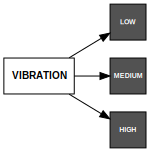

In [16]:
nodes = ['VIBRATION', 'LOW', 'MEDIUM', 'HIGH']
nodes_idx = ['VIBRATION1', 'LOW1', 'MEDIUM1', 'HIGH1']
edges = [('VIBRATION1', 'LOW1'), ('VIBRATION1', 'MEDIUM1'), ('VIBRATION1', 'HIGH1')]

plot_tree(nodes, nodes_idx, edges, [0], [], filename='../slides/figures/outages-idthree-man-1.pdf')

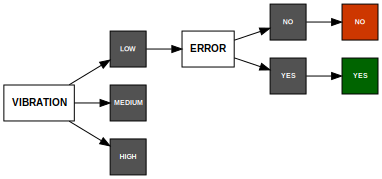

In [17]:
nodes = ['VIBRATION', 'LOW', 'MEDIUM', 'HIGH']
nodes = nodes + ['ERROR', 'NO', 'NO', 'YES', 'YES']

nodes_idx = ['VIBRATION1', 'LOW1', 'MEDIUM1', 'HIGH1']
nodes_idx = nodes_idx + ['ERROR1', 'NO1', 'NO2', 'YES1', 'YES2']

edges = [('VIBRATION1', 'LOW1'), ('VIBRATION1', 'MEDIUM1'), ('VIBRATION1', 'HIGH1')]
edges = edges + [('LOW1', 'ERROR1'), ('ERROR1', 'NO1'), ('NO1', 'NO2'), ('ERROR1', 'YES1'), ('YES1', 'YES2')]

plot_tree(nodes, nodes_idx, edges, [0, 4], [6, 8], filename='../slides/figures/outages-idthree-man-2.pdf')

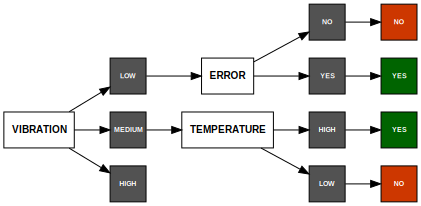

In [18]:
nodes = ['VIBRATION', 'LOW', 'MEDIUM', 'HIGH']
nodes = nodes + ['ERROR', 'NO', 'NO', 'YES', 'YES']
nodes = nodes + ['TEMPERATURE', 'HIGH', 'YES', 'LOW', 'NO']

nodes_idx = ['VIBRATION1', 'LOW1', 'MEDIUM1', 'HIGH1']
nodes_idx = nodes_idx + ['ERROR1', 'NO1', 'NO2', 'YES1', 'YES2']
nodes_idx = nodes_idx + ['TEMPERATURE1', 'HIGH2', 'YES3', 'LOW2', 'YES4']

edges = [('VIBRATION1', 'LOW1'), ('VIBRATION1', 'MEDIUM1'), ('VIBRATION1', 'HIGH1')]
edges = edges + [('LOW1', 'ERROR1'), ('ERROR1', 'NO1'), ('NO1', 'NO2'), ('ERROR1', 'YES1'), ('YES1', 'YES2')]
edges = edges + [('MEDIUM1', 'TEMPERATURE1'), ('TEMPERATURE1', 'HIGH2'), ('HIGH2', 'YES3'), ('TEMPERATURE1', 'LOW2'), ('LOW2', 'YES4')]

plot_tree(nodes, nodes_idx, edges, [0, 4, 9], [6, 8, 11, 13], filename='../slides/figures/outages-idthree-man-3.pdf')

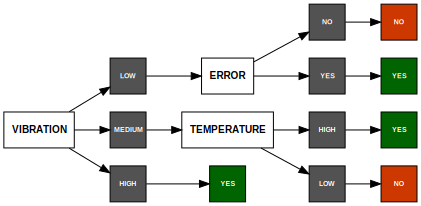

In [19]:
nodes = ['VIBRATION', 'LOW', 'MEDIUM', 'HIGH']
nodes = nodes + ['ERROR', 'NO', 'NO', 'YES', 'YES']
nodes = nodes + ['TEMPERATURE', 'HIGH', 'YES', 'LOW', 'NO']
nodes = nodes + ['YES']

nodes_idx = ['VIBRATION1', 'LOW1', 'MEDIUM1', 'HIGH1']
nodes_idx = nodes_idx + ['ERROR1', 'NO1', 'NO2', 'YES1', 'YES2']
nodes_idx = nodes_idx + ['TEMPERATURE1', 'HIGH2', 'YES3', 'LOW2', 'YES4']
nodes_idx = nodes_idx + ['YES5']

edges = [('VIBRATION1', 'LOW1'), ('VIBRATION1', 'MEDIUM1'), ('VIBRATION1', 'HIGH1')]
edges = edges + [('LOW1', 'ERROR1'), ('ERROR1', 'NO1'), ('NO1', 'NO2'), ('ERROR1', 'YES1'), ('YES1', 'YES2')]
edges = edges + [('MEDIUM1', 'TEMPERATURE1'), ('TEMPERATURE1', 'HIGH2'), ('HIGH2', 'YES3'), ('TEMPERATURE1', 'LOW2'), ('LOW2', 'YES4')]
edges = edges + [('HIGH1', 'YES5')]

plot_tree(nodes, nodes_idx, edges, [0, 4, 9], [6, 8, 11, 13, 14], filename='../slides/figures/outages-idthree-man-4.pdf')

### Python Implementation

In [20]:
data = pd.read_csv('../datasets/demos/outages.csv')
X, y = data.iloc[:, 0:3], data['outage']

hyperparams = {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 
               'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 
               'random_state': 1909, 'max_leaf_nodes': None, 'min_impurity_decrease':0.0, 
               'min_impurity_split': None}

model = DecisionTreeClassifier(**hyperparams)

categorical_featues = ['vibration', 'error', 'temperature']

categorical_transformer = Pipeline([
    ('onehotencoder', OneHotEncoder(drop='first')),
])

preprocessor = ColumnTransformer([
    ('categorical_transformer', categorical_transformer, categorical_featues),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model),
])

pipeline.fit(X, y)

instance = pd.DataFrame({'vibration': ['medium'], 'error': ['no'], 'temperature': ['low']})

prediction = pipeline.predict(instance)[0]
prediction_proba = pipeline.predict_proba(instance)[:,:1][0][0] * 100
print(f'Medium Vibration, Low Temperature, Negative Error Indicator: {prediction} ({prediction_proba}%)')

Medium Vibration, Low Temperature, Negative Error Indicator: no (100.0%)


In [21]:
%%writefile ../slides/snippets/outtage-iterative-dichotomiser-1.py
# Additional Python Packages
from sklearn.tree import DecisionTreeClassifier

# Dataset Import
data = pd.read_csv('../datasets/demos/outages.csv')

# Datset Split into Feature Matrix X and Target Vector y
X, y = data.iloc[:, 0:3], data['outage']

# Hyperparameter Definitions
hyperparams = {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 
               'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 
               'random_state': 1909, 'max_leaf_nodes': None, 'min_impurity_decrease':0.0, 
               'min_impurity_split': None}

# Model Initialization
model = DecisionTreeClassifier(**hyperparams)

Overwriting ../slides/snippets/outtage-iterative-dichotomiser-1.py


In [22]:
%%writefile ../slides/snippets/outtage-iterative-dichotomiser-2.py
# Preprocessing
categorical_featues = ['vibration', 'error', 'temperature']

categorical_transformer = Pipeline([
    ('onehotencoder', OneHotEncoder(drop='first')),
])

preprocessor = ColumnTransformer([
    ('categorical_transformer', categorical_transformer, categorical_featues),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model),
])

# Pipeline and Model Fitting
pipeline.fit(X, y)

Overwriting ../slides/snippets/outtage-iterative-dichotomiser-2.py


In [23]:
%%writefile ../slides/snippets/outtage-iterative-dichotomiser-3.py
# Prediction Dataset Initialization
instance = pd.DataFrame({'vibration': ['medium'], 'error': ['yes'], 'temperature': ['low']})

# Prediction and Output
prediction = pipeline.predict(instance)
prediction_proba = pipeline.predict_proba(instance)
print(f'Prediction result: {prediction} ({prediction_proba})')
> Prediction result: ['no'] ([[1. 0.]]

Overwriting ../slides/snippets/outtage-iterative-dichotomiser-3.py


### Tree Plot

In [24]:
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['onehotencoder'].get_feature_names(X.columns)
classes = y.unique()

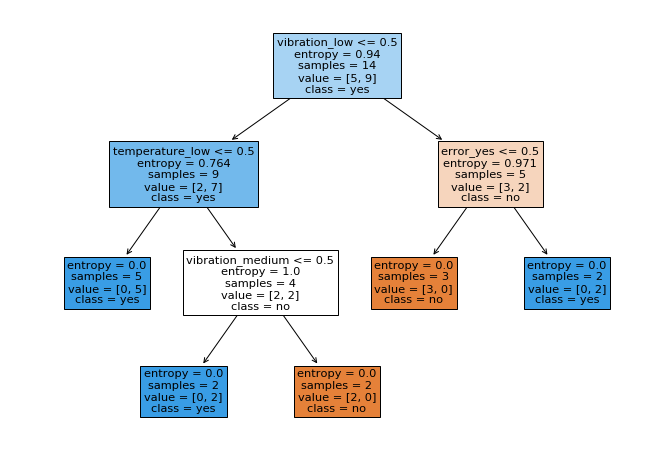

In [25]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT*2))
tree.plot_tree(pipeline['model'], filled=True, feature_names=feature_names, class_names=y.unique(), ax=ax)
plt.savefig('../slides/figures/outages-idthree-decision-tree.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Evaluation

In [26]:
custom_scorer = make_scorer(f1_score, pos_label='yes')
res_cv = cross_validate(pipeline, X, y, scoring=custom_scorer, cv=4, return_train_score=True)
res_acc_tr = np.mean(res_cv['train_score']) * 100
res_acc_te = np.mean(res_cv['test_score']) * 100
print(f'Average F1 on Training and Test Sets: {res_acc_tr:.2f}%/{res_acc_te:.2f}%')

Average F1 on Training and Test Sets: 100.00%/91.67%


In [27]:
%%writefile ../slides/snippets/outage-idthree-evaluation.py
# Additional Import Definitions
from sklearn.metrics import make_scorer

# 4-Fold Cross-Validation with Custom F1 Scorer
custom_scorer = make_scorer(f1_score, pos_label='yes')
res_cv = cross_validate(pipeline, X, y, scoring=custom_scorer, cv=4, return_train_score=True)

# Avverage F1 Calculation and Output for Training and Test Sets
res_f1_tr = np.mean(res_cv['train_score']) * 100
res_f1_te = np.mean(res_cv['test_score']) * 100
print(f'Average F1 on Training and Test Sets: {res_f1_tr:.2f}%/{res_f1_te:.2f}%')
> Average F1 on Training and Test Sets: 100.00%/91.67%

Overwriting ../slides/snippets/outage-idthree-evaluation.py


## Random Forest

In [28]:
hyperparams = {
    'n_estimators': 4, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 
    'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 
    'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 
    'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': 1909, 
    'verbose': 0, 'warm_start': False, 'class_weight': None}

model = RandomForestClassifier(**hyperparams)

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model),
])

pipeline = pipeline.fit(X, y)

In [29]:
%%writefile ../slides/snippets/outage-rf-1.py
# Additional Import Definition
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Definitions
hyperparams = {
    'n_estimators': 4, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 
    'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 
    'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 
    'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': 1909, 
    'verbose': 0, 'warm_start': False, 'class_weight': None}

# Model Reinitialization
model = RandomForestClassifier(**hyperparams)

# Pipeline Reinitialization
pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model),
])

Overwriting ../slides/snippets/outage-rf-1.py


In [30]:
res_cv = cross_validate(pipeline, X, y, scoring=custom_scorer, cv=4, return_train_score=True)
res_acc_tr = np.mean(res_cv['train_score']) * 100
res_acc_te = np.mean(res_cv['test_score']) * 100
print(f'Average F1 on Training and Test Sets: {res_acc_tr:.2f}%/{res_acc_te:.2f}%')

Average F1 on Training and Test Sets: 97.73%/75.00%


In [31]:
%%writefile ../slides/snippets/outage-rf-2.py
# 4-Fold Cross-Validation with Custom F1 Scorer
res_cv = cross_validate(pipeline, X, y, scoring=custom_scorer, cv=4, return_train_score=True)

# Average F1 Calculation and Output for Training and Test Sets
res_f1_tr = np.mean(res_cv['train_score']) * 100
res_f1_te = np.mean(res_cv['test_score']) * 100
print(f'Average F1 on Training and Test Sets: {res_f1_tr:.2f}%/{res_f1_te:.2f}%')
> Average F1 on Training and Test Sets: 97.73%/75.00%

Overwriting ../slides/snippets/outage-rf-2.py


### Tree Plot

In [32]:
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['onehotencoder'].get_feature_names(X.columns)
classes = y.unique()

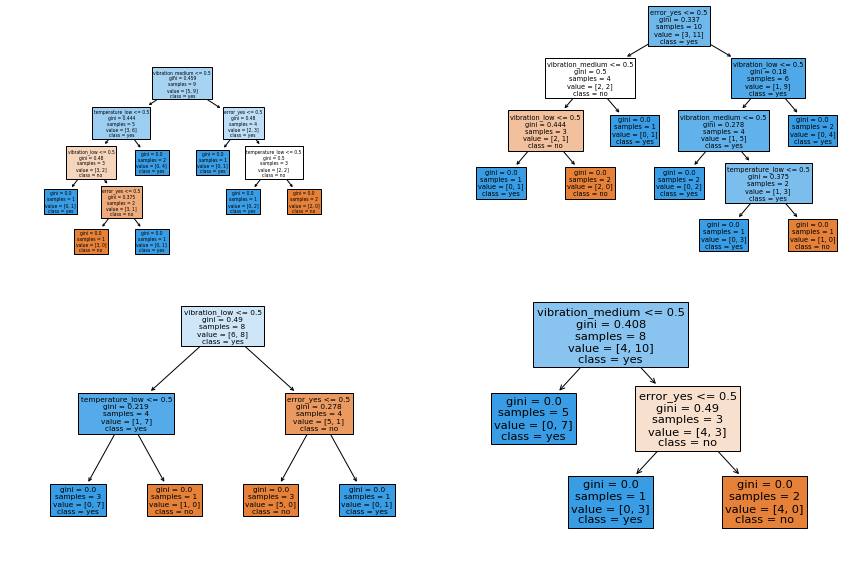

In [33]:
fig = plt.figure(figsize=(12, 8))

for idx, model in enumerate(pipeline.named_steps['model'].estimators_):
    ax = fig.add_subplot(int(f'22{idx + 1}'))
    tree.plot_tree(model, filled=True, feature_names=feature_names, class_names=y.unique(), ax=ax)
    fig.tight_layout()
fig.tight_layout()
plt.savefig('../slides/figures/outages-rf-decision-tree.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Hyperparameter Tuning

In [34]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### Random Search

In [35]:
n_estimators = randint(100, 500)
max_depth = randint(1, 10)

param_distributions = {'model__n_estimators': n_estimators, 'model__max_depth': max_depth}

In [36]:
start = time()
rs = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=5, scoring=custom_scorer, n_jobs=-1, iid=False, cv=4, random_state=1909)
rs = rs.fit(X, y)
print(f"RandomizedSearchCV took {(time() - start):.2f} seconds for {rs.n_iter} candidates parameter settings.\n")
report(rs.cv_results_)

RandomizedSearchCV took 4.57 seconds for 5 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 6, 'model__n_estimators': 442}

Model with rank: 2
Mean validation score: 0.881 (std: 0.137)
Parameters: {'model__max_depth': 5, 'model__n_estimators': 284}

Model with rank: 2
Mean validation score: 0.881 (std: 0.137)
Parameters: {'model__max_depth': 6, 'model__n_estimators': 266}



In [37]:
print(f'Optimal parameters: {rs.best_params_}')

Optimal parameters: {'model__max_depth': 6, 'model__n_estimators': 442}


In [38]:
%%writefile ../slides/snippets/outage-random-search.py
# Additional Import Definition
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter Uniform Sampling Distribution
n_estimators = randint(100, 500)
max_depth = randint(1, 10)
param_distributions = {'model__n_estimators': n_estimators, 'model__max_depth': max_depth}

# Initialize Randomized Search
rs = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=5, 
                        scoring=custom_scorer, n_jobs=-1, iid=False, cv=4, random_state=1909)

# Begin Randomized Search with 4-fold Cross Validation
rs = rs.fit(X, y)

# Output Best Parameters
print(f'Optimal parameters: {rs.best_params_}')
> Optimal parameters: {'model__max_depth': 6, 'model__n_estimators': 442}

Overwriting ../slides/snippets/outage-random-search.py


In [39]:
%%writefile ../slides/snippets/outage-random-search-result.py
RandomizedSearchCV took 2.55 seconds for 5 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 6, 'model__n_estimators': 442}

Model with rank: 2
Mean validation score: 0.881 (std: 0.137)
Parameters: {'model__max_depth': 5, 'model__n_estimators': 284}

Model with rank: 2
Mean validation score: 0.881 (std: 0.137)
Parameters: {'model__max_depth': 6, 'model__n_estimators': 266}
    
...

Overwriting ../slides/snippets/outage-random-search-result.py


#### Grid Search

In [40]:
n_estimators = [100, 200, 300, 400, 500]
max_depth = [1, 2, 3, 5, 6, 7, 8, 9, 10]
param_grid = {'model__n_estimators': n_estimators,  'model__max_depth': max_depth}

In [41]:
start = time()
gs = GridSearchCV(pipeline, param_grid=param_grid, scoring=custom_scorer, n_jobs=-1, iid=False, cv=4)
gs = gs.fit(X, y)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(gs.cv_results_['params'])} candidates parameter settings.\n")
report(gs.cv_results_, n_top=9)

GridSearchCV took 18.40 seconds for 45 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 3, 'model__n_estimators': 400}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 3, 'model__n_estimators': 500}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 5, 'model__n_estimators': 400}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 5, 'model__n_estimators': 500}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 6, 'model__n_estimators': 400}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 6, 'model__n_estimators': 500}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 7, 'model__n_estimators': 400}

Model with rank: 1
Mean validation score: 0.964

In [42]:
gs.best_params_

{'model__max_depth': 3, 'model__n_estimators': 400}

In [43]:
%%writefile ../slides/snippets/outage-grid-search.py
# Additional Import Definition
from sklearn.model_selection import GridSearchCV

# Hyperparameter Grid Setup
n_estimators = [100, 200, 300, 400, 500]
max_depth = [1, 2, 3, 5, 6, 7, 8, 9, 10]
param_grid = {'model__n_estimators': n_estimators,  'model__max_depth': max_depth}

# Initialize Grid Search
gs = GridSearchCV(pipeline, param_grid=param_grid, scoring=custom_scorer, n_jobs=-1, 
                  iid=False, cv=4)
gs = gs.fit(X, y)

# Begin Grid Search with 4-fold Cross Validation
gs = grid_search_cv.fit(X, y)

# Output Best Parameters
print(f'Optimal parameters: {gs.best_params_}')
> Optimal parameters: {'model__max_depth': 3, 'model__n_estimators': 400}

Overwriting ../slides/snippets/outage-grid-search.py


In [44]:
%%writefile ../slides/snippets/outage-grid-result-1.py
GridSearchCV took 17.59 seconds for 45 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 3, 'model__n_estimators': 400}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 3, 'model__n_estimators': 500}

Model with rank: 1
Mean validation score: 0.964 (std: 0.062)
Parameters: {'model__max_depth': 5, 'model__n_estimators': 400}
    
...

Overwriting ../slides/snippets/outage-grid-result-1.py


In [45]:
model = RandomForestClassifier(n_estimators=442, max_depth=6, random_state=1909)

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model),
])

pipeline = pipeline.fit(X, y)

In [46]:
res_cv = cross_validate(pipeline, X, y, scoring=custom_scorer, cv=4, return_train_score=True)
res_acc_tr = np.mean(res_cv['train_score']) * 100
res_acc_te = np.mean(res_cv['test_score']) * 100
print(f'Average F1 on Training and Test Sets: {res_acc_tr:.2f}%/{res_acc_te:.2f}%')

Average F1 on Training and Test Sets: 100.00%/96.43%


In [47]:
%%writefile ../slides/snippets/outage-rf-final.py
# Model Reinitialization
model = RandomForestClassifier(n_estimators=442, max_depth=6, random_state=1909)

# Pipeline Reinitialization and Fitting
pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model),
])

pipeline = pipeline.fit(X, y)

# Average F1 Calculation and Output for Training and Test Sets
res_cv = cross_validate(pipeline, X, y, scoring=custom_scorer, cv=4, return_train_score=True)
res_f1_tr = np.mean(res_cv['train_score']) * 100
res_f1_te = np.mean(res_cv['test_score']) * 100
print(f'Average F1 on Training and Test Sets: {res_f1_tr:.2f}%/{res_f1_te:.2f}%')
> Average F1 on Training and Test Sets: 100.00%/96.43%

Overwriting ../slides/snippets/outage-rf-final.py


## Development Exercise

In [48]:
data = pd.read_csv('../datasets/exercises/backorders.csv')

In [49]:
data.head()

,national_inv,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,ppap_risk,went_on_backorder
0,0.0,0.0,3.0,4.0,6.0,1.0,1.0,3.0,3.0,no,yes
1,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yes,no
2,605.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,90.0,no,no
3,18.0,0.0,37.0,72.0,117.0,8.0,30.0,31.0,31.0,no,no
4,0.0,0.0,12.0,18.0,18.0,0.0,0.0,0.0,0.0,yes,yes


In [62]:
pd.DataFrame([[100, 0, 2, 5, 6, 1, 2, 5, 1, 'no']], columns=data.columns[:-1]).iloc[:, 0:5].to_latex('../slides/tables/backorder-prediction-set.tex', index=False)

In [61]:
pd.DataFrame([[100, 0, 2, 5, 6, 1, 2, 5, 1, 'no']], columns=data.columns[:-1]).iloc[:, 5:10].to_latex('../slides/tables/backorder-prediction-set-1.tex', index=False)